In [1]:
import nltk
import sklearn
import pandas as pd
import numpy as np
from nltk.corpus import CategorizedPlaintextCorpusReader
from nltk import FreqDist
from nltk.corpus import stopwords
import string
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# project module
from benchmark import get_benchmark
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from os import path
import os
import seaborn as sns
sns.set()
from wordcloud import WordCloud

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
#corpus for the uncleaned data
doc_pattern = r'.*\.txt';
cat_pattern = r'([\w_/]+)/.*';
corpus_en =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/Companies2/en/', doc_pattern, cat_pattern=cat_pattern)
corpus_nl =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/Companies2/nl', doc_pattern, cat_pattern=cat_pattern)
corpus = CategorizedPlaintextCorpusReader('/Users/septem/Downloads/Companies2', doc_pattern, cat_pattern = cat_pattern)
len(corpus_en.fileids()), len(corpus_nl.fileids())

(928, 3954)

In [3]:
pd.DataFrame([{'innov': len(corpus_en.fileids('innov')),'others': len(corpus_en.fileids('others'))},
             {'innov': len(corpus_nl.fileids('innov')),'others': len(corpus_nl.fileids('others'))}], index=['english','dutch'])

,innov,others
english,609,319
dutch,2048,1906


In [27]:
def visualize_word_frequency(corpus, title = ''):
    vectorizer = CountVectorizer()
    docs       = vectorizer.fit_transform(corpus.raw(id) for id in corpus.fileids())
    features   = vectorizer.get_feature_names()
    plt.figure(figsize=(12,8))
    if title:
        visualizer = FreqDistVisualizer(features=features, title=title, size=(900,600))
    else:
        visualizer = FreqDistVisualizer(features=features)
    visualizer.fit(docs)
    for label in visualizer.ax.texts:
        label.set_size(20)
    visualizer.poof()

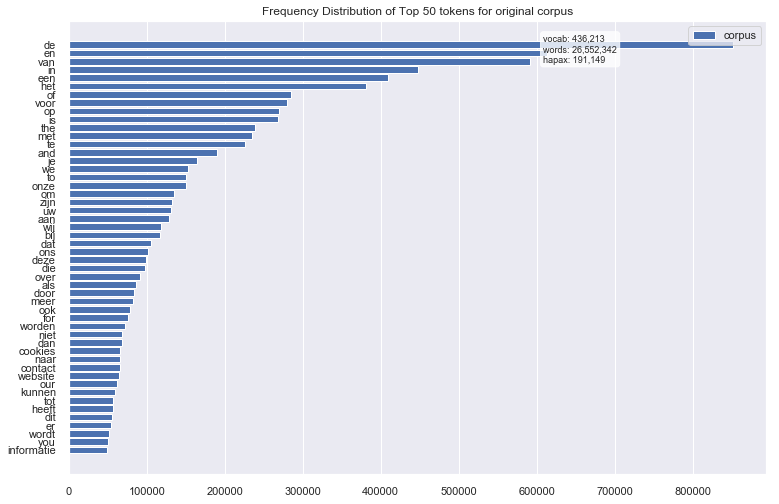

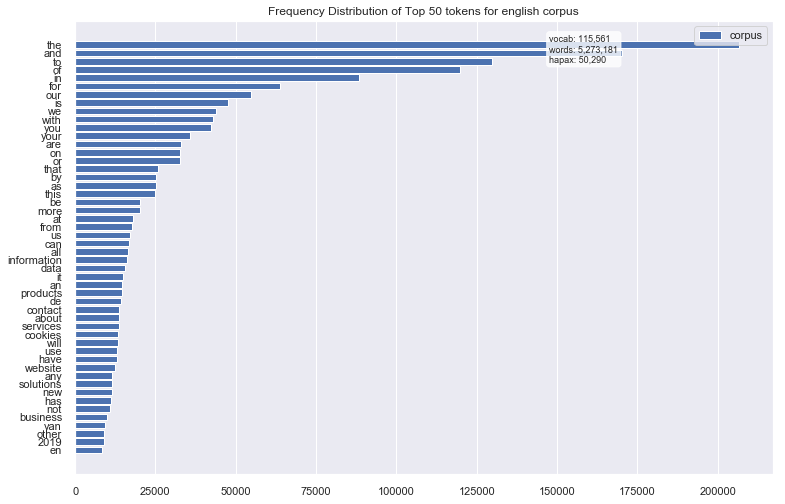

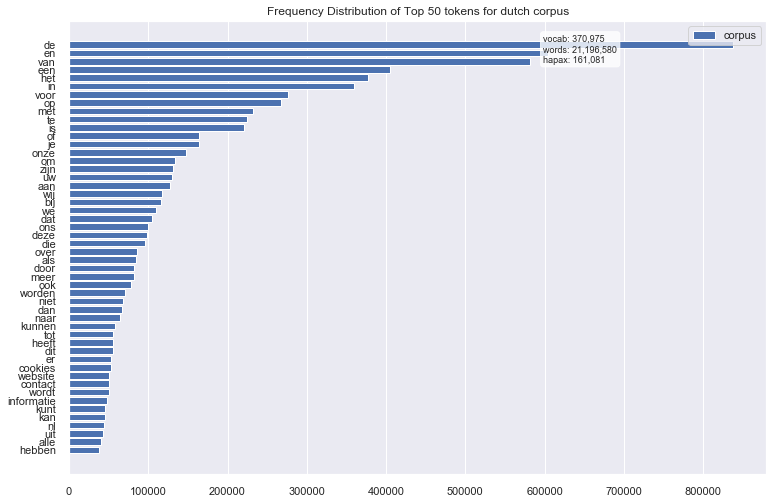

In [30]:
visualize_word_frequency(corpus, title='Frequency Distribution of Top 50 tokens for original corpus')
visualize_word_frequency(corpus_en, title='Frequency Distribution of Top 50 tokens for english corpus')
visualize_word_frequency(corpus_nl, title='Frequency Distribution of Top 50 tokens for dutch corpus')

In [216]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
REPLACE_BY_SPACE_RE = re.compile(r'[/(){}\[\]\|@]')
BAD_SYMBOLS_RE = re.compile(r'[^0-9a-z#+_]')
ALPHANUM_RE = re.compile(r'\W+')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(set(stopwords.words('dutch')))
STOPWORDS.update(set(w for w in string.punctuation))

from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer
# replace email address, phone number, web address and digit with corresponding words
email_exp = re.compile(r'\b([\w_\-\.]+?)@([\w_\-\.]+?)\.([a-z]{2,5})\b', re.IGNORECASE)
tel_exp  = re.compile(r'\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}')
# web_reg = re.compile(r'http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?')
# web_reg = re.compile(r'\b(https?|www).*?\.[a-z]{2,4}\b', re.IGNORECASE)
web_exp = re.compile(r'\b[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)\b', re.IGNORECASE)
digit_exp = re.compile(r'\d+')
stemmer_en = SnowballStemmer('english')
stemmer_nl = SnowballStemmer('dutch')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()


def clean_text(text, stemmer):
    """
        text: a string
        
        return: modified initial string
    """
    
    text = text.lower() # lowercase text
    text = email_exp.sub(' ', text)
#     text = tel_exp.sub('phonenumber', text)
    text = web_exp.sub(' ',text)
#     text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#     text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = digit_exp.sub(' ', text)  
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
#     text = ALPHANUM_RE.sub(' ', text)
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    
    return text



In [243]:
df = create_dataframe(corpus)
df.head()

,innov,lang
id,,
en/innov/10000232.txt,1,en
en/innov/10000364.txt,1,en
en/innov/10010653.txt,1,en
en/innov/10013385.txt,1,en
en/innov/10025316.txt,1,en


In [8]:
doc_pattern = r'.*\.txt';
cat_pattern = r'([\w_/]+)/.*';
corpus_en_cleaned =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/en/', doc_pattern, cat_pattern=cat_pattern)
corpus_nl_cleaned =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/nl/', doc_pattern, cat_pattern=cat_pattern)
corpus_cleaned = CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/', doc_pattern, cat_pattern = cat_pattern)
len(corpus_en_cleaned.fileids()), len(corpus_nl_cleaned.fileids())

(900, 3884)

In [161]:
clean_text(corpus.raw('en/others/10158901.txt'))

'© heetman papenvoort ah, geldrop zesgehuchten han heetman: interior product design intuitive self-explanatory form use iconic recognizeble character clean unnecessary decoration smart innovative solution home product profile press publication client contact'

In [151]:
corpus_cleaned.raw('en/others/10158901.txt')

'© heetman papenvoort ah, geldrop zesgehuchten hans heetman: interior product design intuitive self-explanatory form use iconic recognizeble characters clean unnecessary decoration smart innovative solutions home products profile press publications clients contact'

In [58]:
[id for id in corpus.fileids() if id.find('10158901')>0]

['en/others/10158901.txt']

In [178]:
corpus.categories('en/innov/10000232.txt')

['en/innov']

In [218]:
#preprocess and store in new folder
directory = '/Users/septem/Downloads/companies_cleaned'
for id in corpus.fileids():
    text = corpus.raw(id)
    lang = df.loc[id]['lang']
    if lang == 'en':
        stemmer = stemmer_en
    else:
        stemmer = stemmer_nl
    text = clean_text(text, stemmer)
    if len(text) > 100: 
        p = path.join(directory, id)
        folder = os.path.dirname(p)
        if not path.exists(folder):
            os.makedirs(folder)
        with open(p, 'w+') as f:
            f.write(text)
    
    

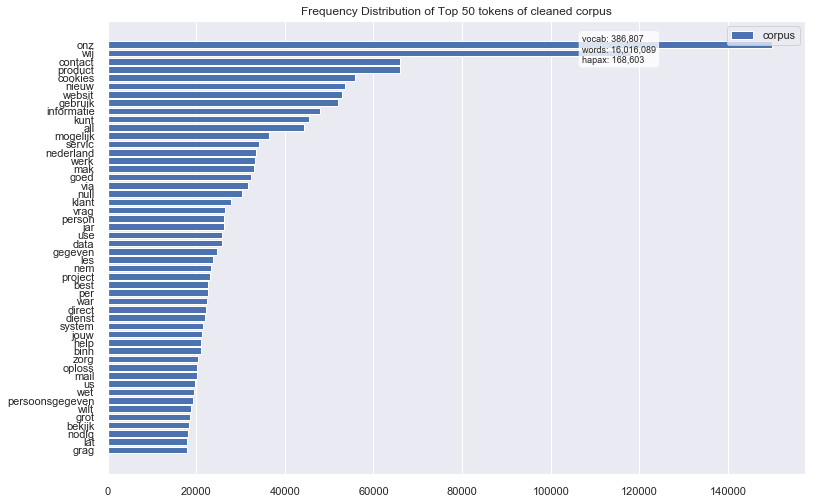

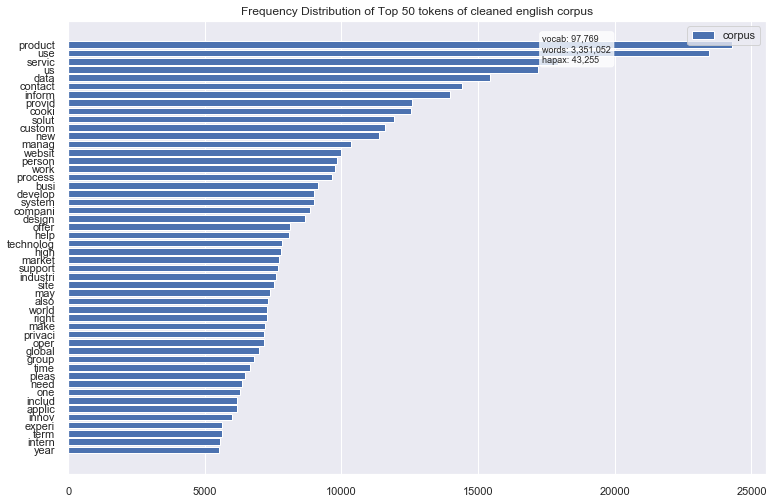

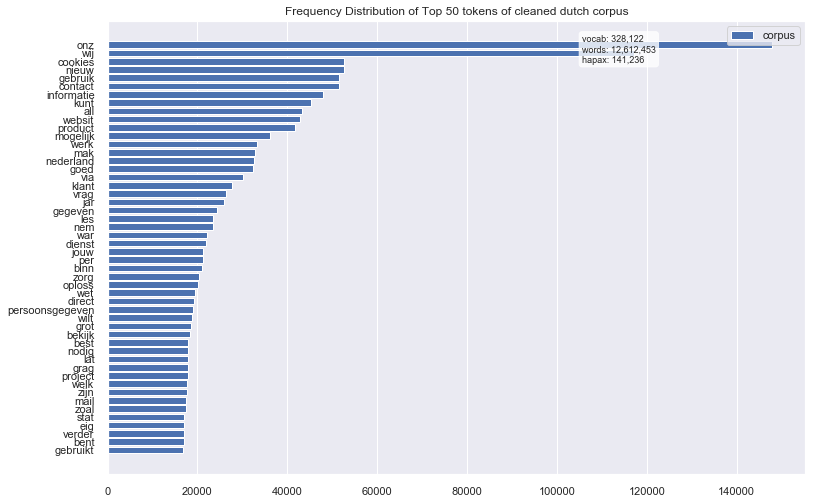

In [29]:
# word frequency after preprocessing 
visualize_word_frequency(corpus_cleaned, title='Frequency Distribution of Top 50 tokens of cleaned corpus')
visualize_word_frequency(corpus_en_cleaned, title='Frequency Distribution of Top 50 tokens of cleaned english corpus')
visualize_word_frequency(corpus_nl_cleaned, title='Frequency Distribution of Top 50 tokens of cleaned dutch corpus')

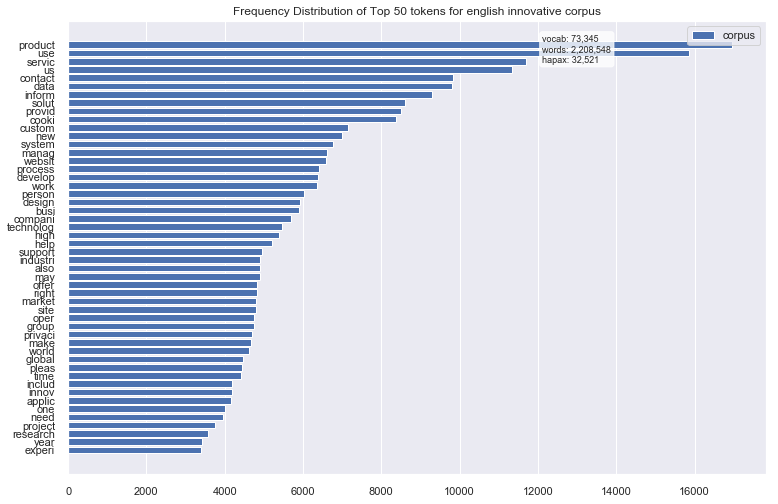

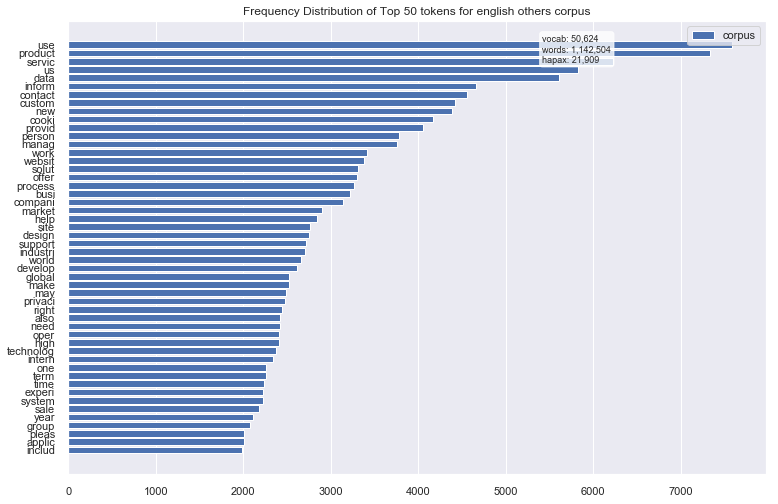

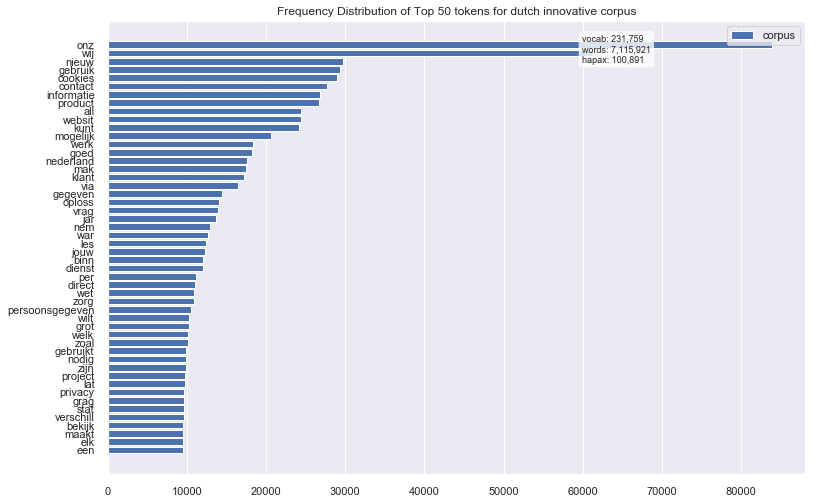

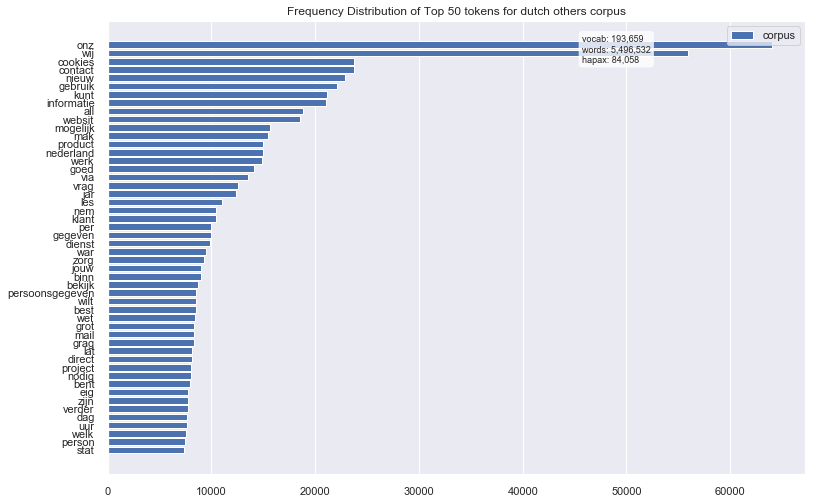

In [28]:
corpus_en_innov =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/en/innov/', doc_pattern, cat_pattern=cat_pattern)
corpus_en_others =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/en/others/', doc_pattern, cat_pattern=cat_pattern)
corpus_nl_innov =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/nl/innov/', doc_pattern, cat_pattern=cat_pattern)
corpus_nl_others =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/nl/others/', doc_pattern, cat_pattern=cat_pattern)
visualize_word_frequency(corpus_en_innov, title='Frequency Distribution of Top 50 tokens for english innovative corpus')
visualize_word_frequency(corpus_en_others, title='Frequency Distribution of Top 50 tokens for english others corpus')
visualize_word_frequency(corpus_nl_innov, title='Frequency Distribution of Top 50 tokens for dutch innovative corpus')
visualize_word_frequency(corpus_nl_others, title='Frequency Distribution of Top 50 tokens for dutch others corpus')

In [261]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer

# Load the data and create document vectors
def visualize_tsne(corpus, estimater):
    tfidf = TfidfVectorizer()

    X = tfidf.fit_transform(corpus.raw(id) for id in corpus.fileids())
    y =  [corpus.categories(id)[0] for id in corpus.fileids()]

    # Create the visualizer and draw the vectors
    tsne = TSNEVisualizer()
    tsne.fit(X,y)
    tsne.show()

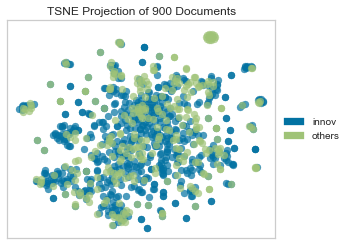

In [258]:
visualize_tsne(corpus_en_cleaned)

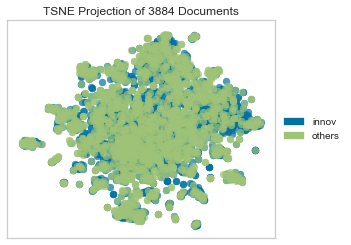

In [259]:
visualize_tsne(corpus_nl_cleaned)

In [454]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)
from PIL import Image
def plot_word_cloud(data, stop_words=[], mode = 'text'):
    
    mask = np.array(Image.open("./NL spoorkaartin.gif"))
    wc = WordCloud(stopwords=stop_words, mask=mask, background_color="white", colormap="viridis", width=800, height=1000,
    max_font_size=150, contour_width=3, contour_color='firebrick')
    if mode == 'text':
        wc.generate(data)
    elif mode == 'frequency':
        wc.generate_from_frequencies(data)
#     wc.recolor(color_func=grey_color_func)
    plt.figure(figsize=(16,20))
    plt.tight_layout(pad=0)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

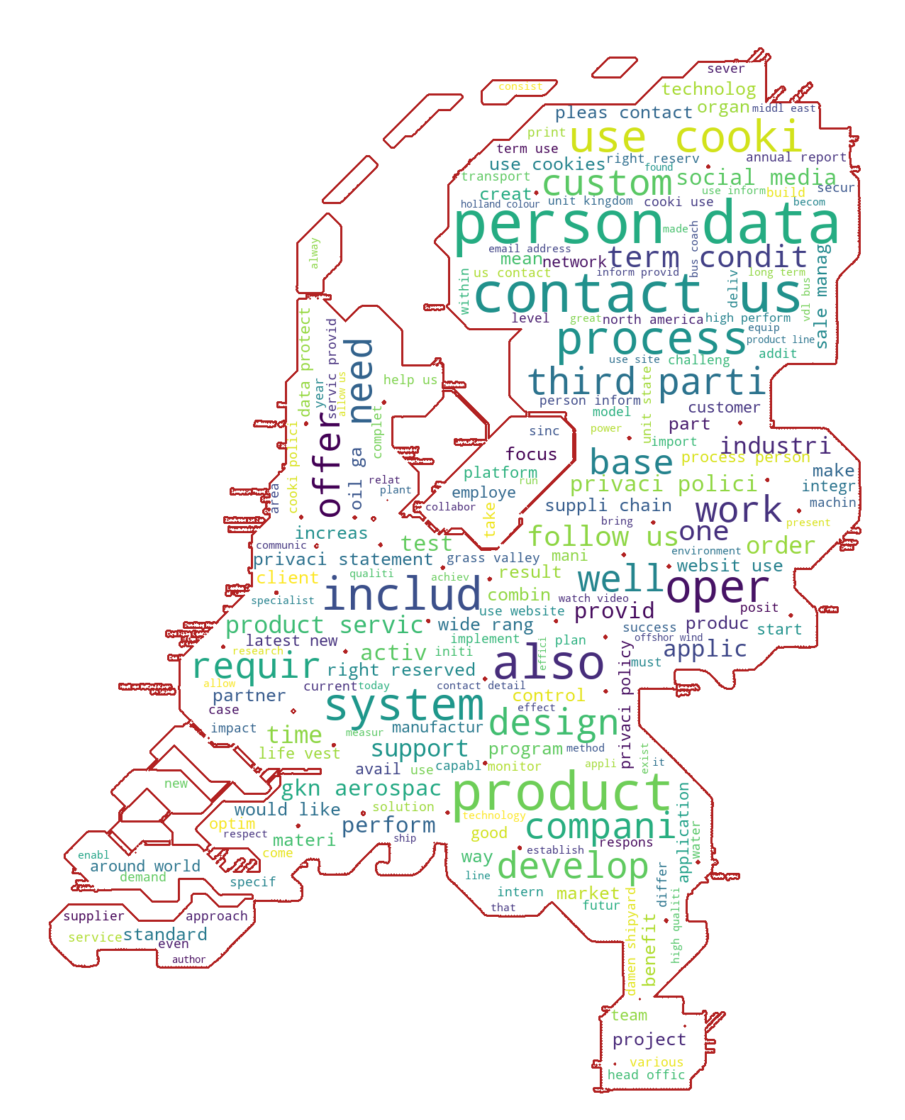

In [304]:
plot_word_cloud(' '.join(corpus_en_cleaned.raw(id) for id in corpus_en_cleaned.fileids() if corpus_en.categories(id)[0] == 'innov'))

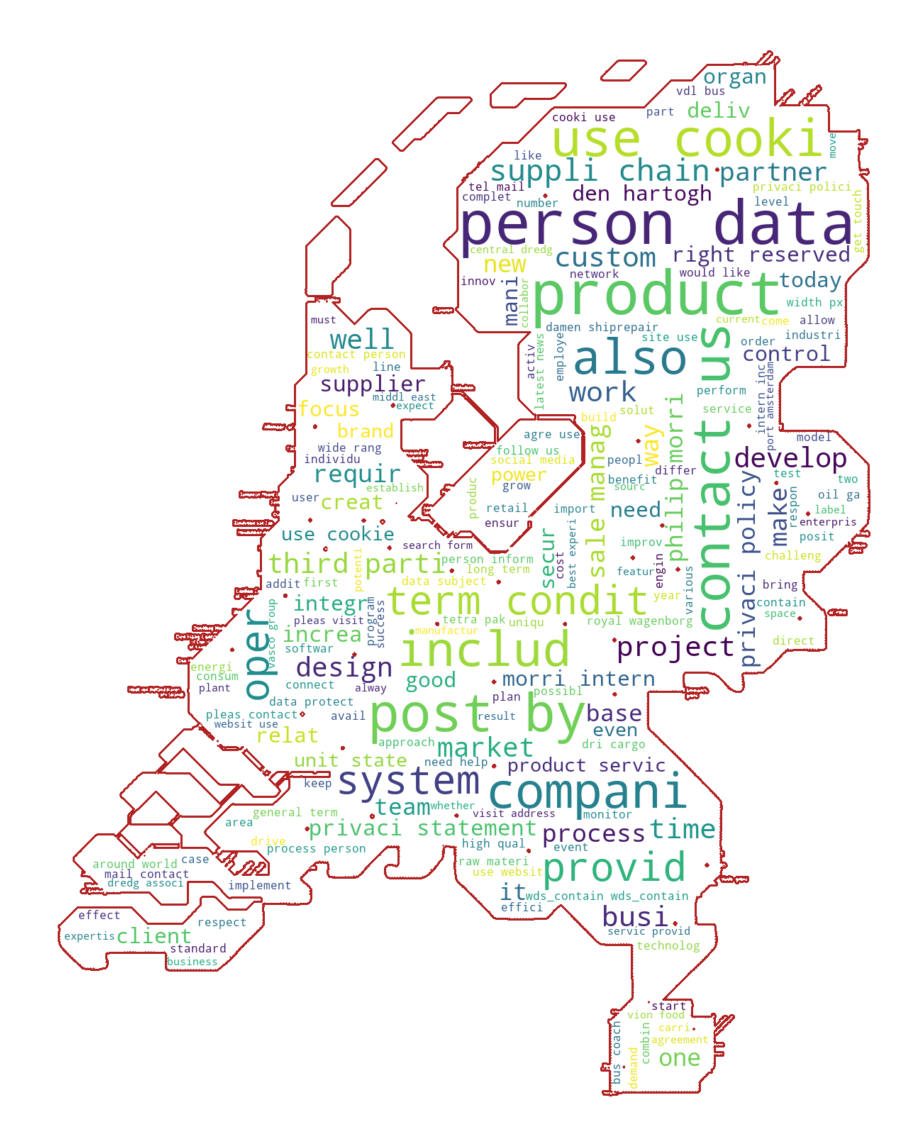

In [541]:
plot_word_cloud(' '.join(corpus_en_cleaned.raw(id) for id in corpus_en_cleaned.fileids() if corpus_en.categories(id)[0] == 'others'))

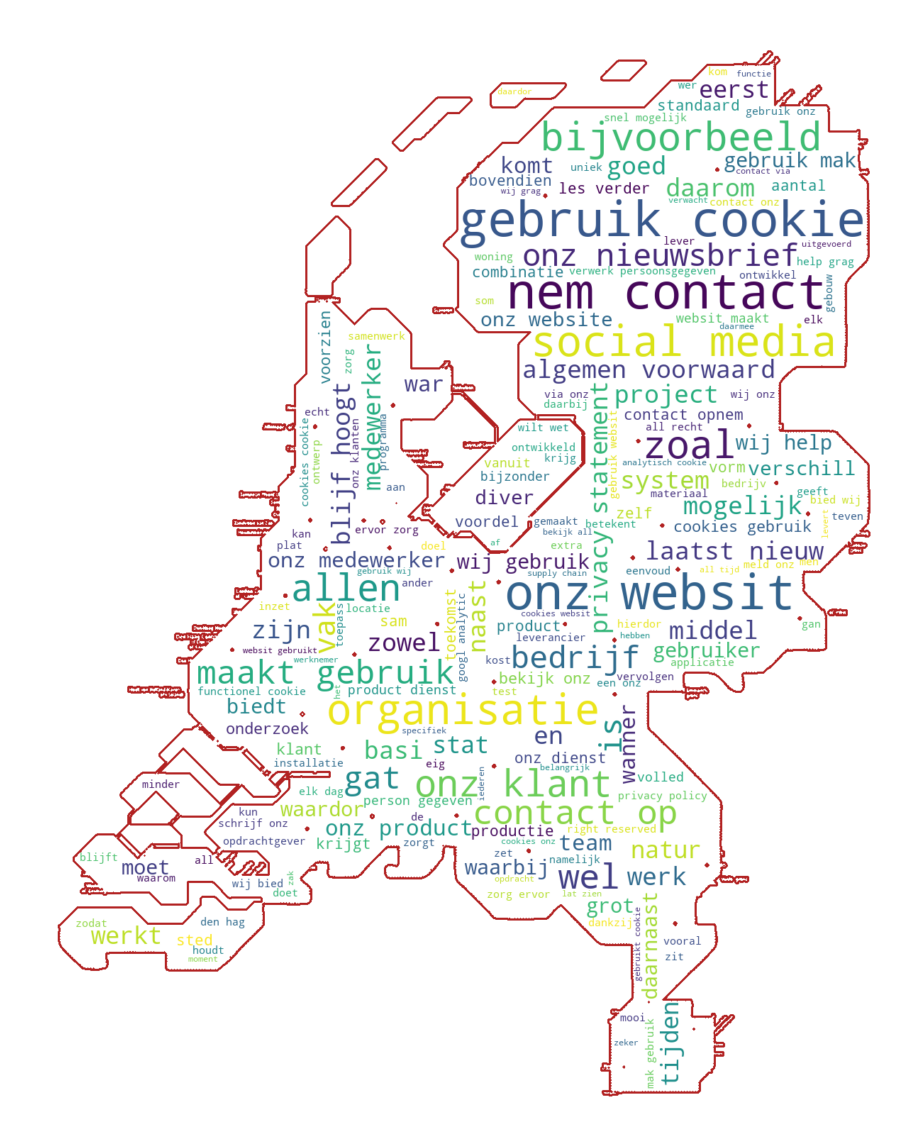

In [542]:
plot_word_cloud(' '.join(corpus_nl_cleaned.raw(id) for id in corpus_nl_cleaned.fileids() if corpus_nl.categories(id)[0] == 'innov'))

In [386]:
cvr = CountVectorizer()
cvr.fit([corpus_cleaned.raw(id) for id in df_en['id']])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [387]:
X_train = cvr.transform(corpus_cleaned.raw(id) for id in x_train)
X_test = cvr.transform(corpus_cleaned.raw(id) for id in x_test)

In [478]:
tfidf = TfidfVectorizer()
tfidf.fit([corpus_cleaned.raw(id) for id in df_en['id']])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [479]:
X_train_tfidf = tfidf.transform(corpus_cleaned.raw(id) for id in x_train)
X_test_tfidf = tfidf.transform(corpus_cleaned.raw(id) for id in x_test)

In [446]:
clf = LogisticRegression().fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test), target_names = ['innov', 'others']))

              precision    recall  f1-score   support

       innov       0.33      0.31      0.32        65
      others       0.73      0.74      0.73       160

    accuracy                           0.62       225
   macro avg       0.53      0.53      0.53       225
weighted avg       0.61      0.62      0.61       225



/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [457]:
name_coef_pair = [(name, coef) for name, coef in zip(cvr.get_feature_names(), clf.coef_[0])]
name_coef_pair = sorted(name_coef_pair, key = lambda x: x[1], reverse = True)
name_coef_dict = {name: coef for name, coef in name_coef_pair}

In [464]:
name_coef_pair[:30]

[('develop', 0.5324818849788542),
 ('machin', 0.4012690769322567),
 ('marin', 0.3793250526575869),
 ('fetim', 0.3766656282603463),
 ('busi', 0.3429709678464331),
 ('address', 0.3333912576137447),
 ('applic', 0.3328987278229925),
 ('solut', 0.3043156763972781),
 ('work', 0.2986037350983741),
 ('polici', 0.29509513547388583),
 ('navig', 0.29089103139887534),
 ('innov', 0.29047886725105254),
 ('power', 0.2869742858408632),
 ('manufactur', 0.2787510295855961),
 ('research', 0.27660265795749),
 ('irdeto', 0.27473553142060064),
 ('domain', 0.2734439491078754),
 ('aarsen', 0.26816272790376566),
 ('better', 0.26809930729047166),
 ('network', 0.265515458471567),
 ('wast', 0.2533468591493028),
 ('technic', 0.25227368450764176),
 ('day', 0.251728498229822),
 ('valu', 0.24818781901509498),
 ('produc', 0.2472563806948102),
 ('lapp', 0.2451165266246011),
 ('heat', 0.24225125509301684),
 ('good', 0.2418763319078623),
 ('charg', 0.23100788817431417),
 ('media', 0.2303536491191435)]

In [470]:
def plot_top_coef(name_coef_pair, title=''):
    plt.figure(figsize=(16,9))
    plt.title(title)
    plt.barh(*zip(*name_coef_pair))

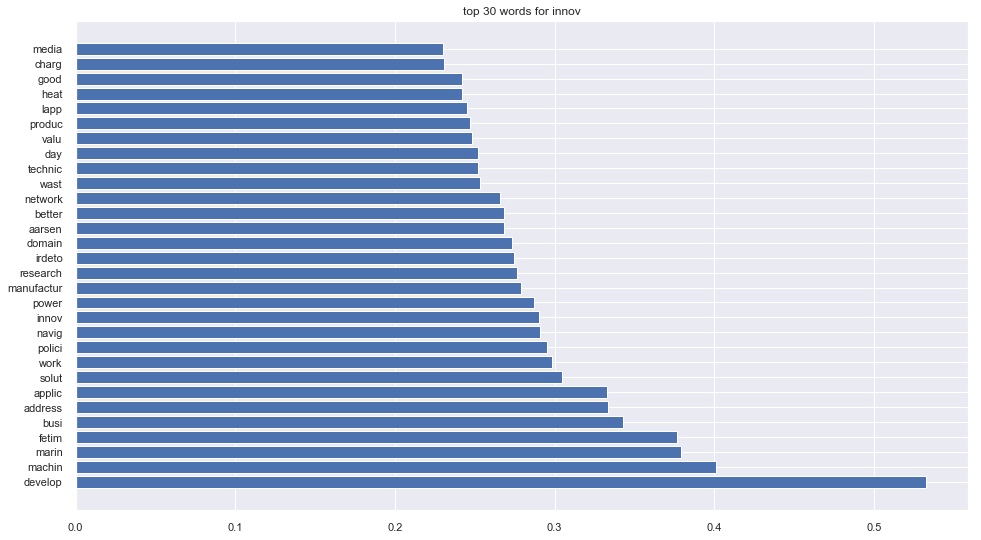

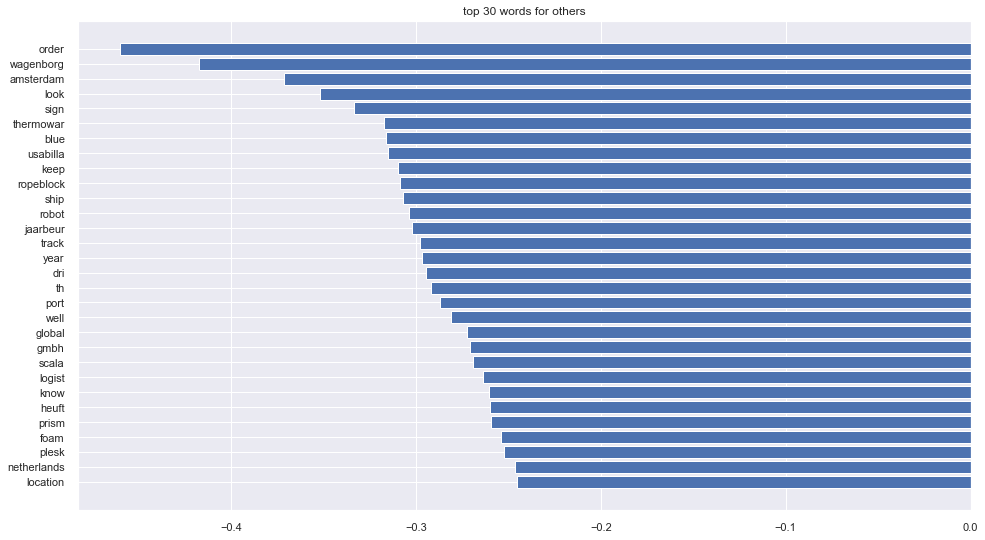

In [472]:
plot_top_coef(name_coef_pair[:30], title = 'top 30 words for innov')
plot_top_coef(name_coef_pair[-30:], title = 'top 30 words for others')

In [480]:
clf = LogisticRegression().fit(X_train_tfidf, y_train)
print(classification_report(y_test, clf.predict(X_test_tfidf), target_names = ['innov', 'others']))

              precision    recall  f1-score   support

       innov       0.80      0.06      0.11        65
      others       0.72      0.99      0.84       160

    accuracy                           0.72       225
   macro avg       0.76      0.53      0.48       225
weighted avg       0.75      0.72      0.63       225



In [481]:
name_coef_pair = [(name, coef) for name, coef in zip(tfidf.get_feature_names(), clf.coef_[0])]
name_coef_pair = sorted(name_coef_pair, key = lambda x: x[1], reverse = True)
name_coef_dict = {name: coef for name, coef in name_coef_pair}

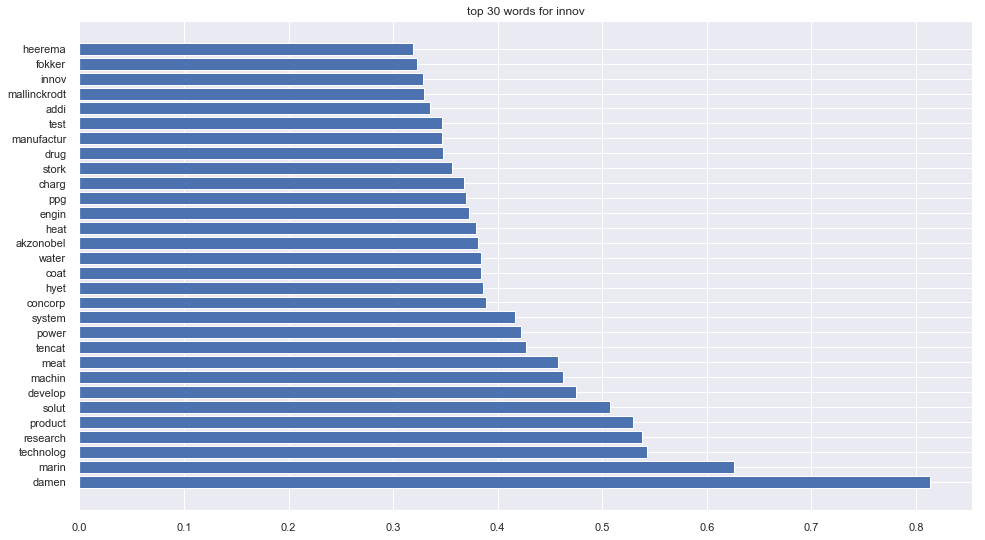

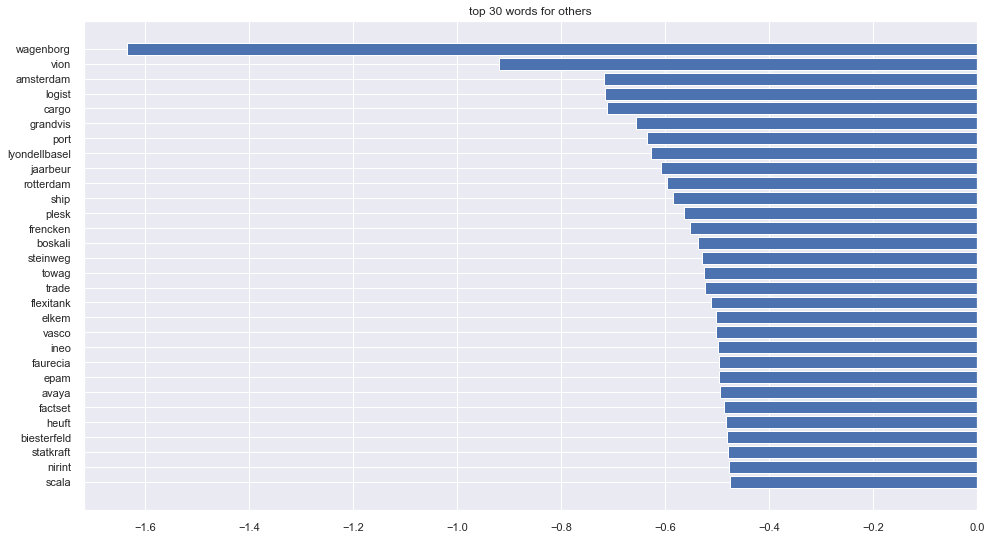

In [483]:
plot_top_coef(name_coef_pair[:30], title = 'top 30 words for innov')
plot_top_coef(name_coef_pair[-30:], title = 'top 30 words for others')

In [485]:
from sklearn.decomposition import TruncatedSVD
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train_tfidf)
X_train_svd = svd.transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

scale = StandardScaler()
scale.fit(X_train_svd)
X_train_svd_scale = scale.transform(X_train_svd)
X_test_svd_scale = scale.transform(X_test_svd)

SVMclf = SVC()
SVMclf.fit(X_train_svd_scale, y_train)
y_pred = SVMclf.predict(X_test_svd_scale)
print(classification_report(y_test, y_pred, target_names = ['innov', 'others']))

              precision    recall  f1-score   support

       innov       0.62      0.08      0.14        65
      others       0.72      0.98      0.83       160

    accuracy                           0.72       225
   macro avg       0.67      0.53      0.48       225
weighted avg       0.70      0.72      0.63       225



(array([390.,  84.,  79.,  53.,  43.,  51.,  41.,  62.,  54.,  23.]),
 array([  144.,  9069., 17994., 26919., 35844., 44769., 53694., 62619.,
        71544., 80469., 89394.]),
 <a list of 10 Patch objects>)

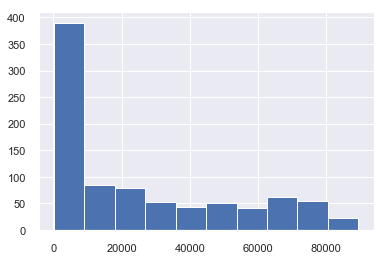

In [507]:
len_per_text = [(id, len(corpus_en_cleaned.raw(id))) for id in corpus_en_cleaned.fileids()]
len_per_text = sorted(len_per_text, key = lambda x: x[1])
plt.hist([l for id, l in len_per_text[10:-10]], bins=10)

In [511]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [513]:
model_doc2vec = Doc2Vec([TaggedDocument(word_tokenize(corpus_en_cleaned.raw(id)), [id]) for id in corpus_en_cleaned.fileids()],
       size = 100, min_count=0)

/Users/septem/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [521]:
model_doc2vec.docvecs[1].shape

(100,)

In [537]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB(alpha=0, class_prior=[0.66,0.34])
clf_nb.fit(X_train,y_train)

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


MultinomialNB(alpha=0, class_prior=[0.66, 0.34], fit_prior=True)

In [538]:
print(classification_report(y_test, clf_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.32      0.28      0.30        65
           1       0.72      0.76      0.74       160

    accuracy                           0.62       225
   macro avg       0.52      0.52      0.52       225
weighted avg       0.61      0.62      0.61       225



In [469]:
stop_en =set(stopwords.words('english'))
punctuation = set(w for w in string.punctuation)
stop_en.update(punctuation)

In [6]:
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer
# replace email address, phone number, web address and digit with corresponding words
email_exp = re.compile(r'([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})')
tel_exp  = re.compile(r'\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}')
# web_reg = re.compile(r'http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?')
web_reg = re.compile(r'(https?:\/\/)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)')
stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

class CustomVectorizer(TfidfVectorizer): 
    
    # overwrite the build_analyzer method, allowing one to
    # create a custom analyzer for the vectorizer
    def build_analyzer(self):
        
        stop_words = self.get_stop_words()
        
        # create the analyzer that will be returned by this method
        def analyser(text):    
            text = text.lower()
            text = email_exp.sub('emailaddress', text)
            text = tel_exp.sub('phonenumber', text)
            text = web_reg.sub('webaddress',text)
#             print(text+"\n")
            tokens = []
            for token in word_tokenize(text):
#                 token = stemmer.stem(token)
                token = lemmatizer.lemmatize(token)
                if token.isdigit():
                    token = 'digit'
                if len(token)>=2 and token.isalnum():
                    tokens.append(token)

            return(self._word_ngrams(tokens, stop_words))
        
        return analyser
    
class CustomCountVectorizer(CountVectorizer): 
    
    # overwrite the build_analyzer method, allowing one to
    # create a custom analyzer for the vectorizer
    def build_analyzer(self):
        
        stop_words = self.get_stop_words()
        
        # create the analyzer that will be returned by this method
        def analyser(text):    
            text = text.lower()
            text = email_exp.sub('emailaddress', text)
            text = tel_exp.sub('phonenumber', text)
            text = web_reg.sub('webaddress',text)
#             print(text+"\n")
            tokens = []
            for token in word_tokenize(text):
#                 token = stemmer.stem(token)
                token = lemmatizer.lemmatize(token)
                if token.isdigit():
                    token = 'digit'
                if len(token)>=2 and token.isalnum():
                    tokens.append(token)

            return(self._word_ngrams(tokens, stop_words))
        
        return analyser


In [377]:
corpus_en.raw('others/55495338.txt')

'devoteam\n0 result\nSelect your location\n#TECH\r\nFOR PEOPLE\nDevoteam levert\xa0Innovatieve Technologie Consultancy\nvoor Business.\nWe are #digitaltransformakers\nTrainingen\nDevoteam Academy\nOnze oplossingen\nTransformation Management\nAgile IT Platform\nDigital Workplace\nCyber Security\nData & Analytics\nBusiness Process Excellence\nCustomer Experience\nTechnologie voor mensen\nLaatste nieuws\nLaatste case studies\nKom bij ons werken\nPr. Catharina-Amaliastraat 5 \n2496 XD \nThe Hague\nThe Netherlands\n+31 70 301 1720\nTerms and conditions \n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tcopyright 2019 devoteam ©\nBy continuing your visit to this site, you accept the use of cookies. For more information, to manage or change the settings of cookies on your computer, please read our Privacy Policy.\n'

In [374]:
for i,(id, l) in enumerate(len_per_text[0:200]):
    print("{} {}: {}".format(i,id,l))

0 others/42410886.txt: 19
1 others/30925819.txt: 23
2 innov/73571334.txt: 30
3 others/18001181.txt: 36
4 others/57266670.txt: 36
5 innov/24038237.txt: 37
6 others/12608858.txt: 44
7 innov/18324932.txt: 48
8 others/62196472.txt: 61
9 innov/18304729.txt: 62
10 innov/71061274.txt: 63
11 others/33612153.txt: 65
12 innov/25993097.txt: 74
13 others/10032592.txt: 77
14 innov/59541210.txt: 80
15 others/25112996.txt: 80
16 others/18298273.txt: 85
17 others/59020288.txt: 85
18 innov/62136763.txt: 86
19 innov/10078541.txt: 90
20 innov/67811248.txt: 114
21 others/51003295.txt: 114
22 others/71447407.txt: 134
23 innov/26250721.txt: 137
24 innov/26496046.txt: 140
25 others/23193956.txt: 141
26 innov/10056564.txt: 143
27 innov/15926494.txt: 144
28 innov/27121895.txt: 148
29 others/64370488.txt: 148
30 innov/10800298.txt: 171
31 innov/14991489.txt: 182
32 innov/62168088.txt: 194
33 innov/11501774.txt: 198
34 innov/31722466.txt: 200
35 others/36447897.txt: 202
36 others/20534663.txt: 203
37 others/3310

In [373]:
np.mean([l for id, l in len_per_text]), np.median([l for id, l in len_per_text])

(38391.83512931035, 19911.5)

In [341]:
len_per_text

[('others/42410886.txt', 19),
 ('others/30925819.txt', 23),
 ('innov/73571334.txt', 30),
 ('others/18001181.txt', 36),
 ('others/57266670.txt', 36),
 ('innov/24038237.txt', 37),
 ('others/12608858.txt', 44),
 ('innov/18324932.txt', 48),
 ('others/62196472.txt', 61),
 ('innov/18304729.txt', 62),
 ('innov/71061274.txt', 63),
 ('others/33612153.txt', 65),
 ('innov/25993097.txt', 74),
 ('others/10032592.txt', 77),
 ('innov/59541210.txt', 80),
 ('others/25112996.txt', 80),
 ('others/18298273.txt', 85),
 ('others/59020288.txt', 85),
 ('innov/62136763.txt', 86),
 ('innov/10078541.txt', 90),
 ('innov/67811248.txt', 114),
 ('others/51003295.txt', 114),
 ('others/71447407.txt', 134),
 ('innov/26250721.txt', 137),
 ('innov/26496046.txt', 140),
 ('others/23193956.txt', 141),
 ('innov/10056564.txt', 143),
 ('innov/15926494.txt', 144),
 ('innov/27121895.txt', 148),
 ('others/64370488.txt', 148),
 ('innov/10800298.txt', 171),
 ('innov/14991489.txt', 182),
 ('innov/62168088.txt', 194),
 ('innov/115017

In [8]:
# tfidf vectorization
#too little text scrapped
bypassed_corpus = set([id for id,l in len_per_text[:100]])
df = generate_test_train_split(corpus_en,bypassed_corpus)
x_train,x_test, y_train, y_test = train_test_split(df['id'], df['innov'], random_state = 42, test_size = 0.1)

In [379]:

vec = CustomVectorizer(stop_words=stop_en, max_features = 3000)
x_train = vec.fit_transform(corpus_en.raw(id) for id in x_train)
x_test = vec.transform(corpus_en.raw(id) for id in x_test)
x_train.shape, x_test.shape

((745, 3000), (83, 3000))

In [381]:
with open('x_train_en.pickle', 'wb') as f:
    pickle.dump(x_train, f)
with open('vectorizer_en', 'wb') as f:
    pickle.dump(vec, f)
with open('x_test_en.pickle', 'wb') as f:
    pickle.dump(x_test, f)

In [40]:
#generate and visualize frequency table
c_vec = CustomCountVectorizer(stop_words=stop_en)
word_frequency = c_vec.fit_transform(corpus_en.raw(id) for id in corpus_en.fileids())

In [43]:
with open('./count_matrix_en.pickle','wb') as f:
    pickle.dump(word_frequency, f)
with open('./count_vec_en.pickle','wb') as f:
    pickle.dump(c_vec, f)

In [318]:
word_count = np.sum(word_frequency,axis=0)
word_count = np.asarray(word_count)[0]
frequency_table = ((word, count) for word, count in zip(c_vec.get_feature_names(), word_count))
sorted_frequency_table = sorted(frequency_table, key = lambda x: -x[1])

In [319]:
sorted_frequency_table[:10]

[('digit', 114917),
 ('product', 22026),
 ('service', 21355),
 ('information', 15996),
 ('website', 15206),
 ('data', 15177),
 ('de', 14354),
 ('solution', 14347),
 ('contact', 14116),
 ('cooky', 13221)]

# load from here

In [9]:
with open('./x_train_en.pickle','rb') as f:
    x_train_v = pickle.load(f)
with open('./x_test_en.pickle','rb') as f:
    x_test_v = pickle.load(f)
with open('./vectorizer_en','rb') as f:
    vec = pickle.load(f)

In [199]:
# text = ["hello yiping@yeah.net The stop is not removed 23-445444, http://www.google.com http://www.baidu.com yiping@gmail.com, world",
#        "Regex if you want to ensure URL starts with HTTP/HTTPS:",
#        "question - why the double slash inside the last character class? "]
# vec.fit_transform(text).toarray()

array([[0.        , 0.        , 0.        , 0.57735027, 0.        ,
        0.28867513, 0.        , 0.        , 0.        , 0.        ,
        0.28867513, 0.        , 0.        , 0.28867513, 0.        ,
        0.        , 0.57735027, 0.28867513],
       [0.        , 0.        , 0.        , 0.        , 0.4472136 ,
        0.        , 0.        , 0.        , 0.        , 0.4472136 ,
        0.        , 0.        , 0.4472136 , 0.        , 0.4472136 ,
        0.4472136 , 0.        , 0.        ],
       [0.37796447, 0.37796447, 0.37796447, 0.        , 0.        ,
        0.        , 0.37796447, 0.37796447, 0.37796447, 0.        ,
        0.        , 0.37796447, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.120s
test time:  0.003s
accuracy:   0.675
dimensionality: 3000
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.71      0.17      0.27        30
      others       0.67      0.96      0.79        53

    accuracy                           0.67        83
   macro avg       0.69      0.56      0.53        83
weighted avg       0.69      0.67      0.60        83

confusion matrix:


/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:557: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


<Figure size 432x288 with 0 Axes>

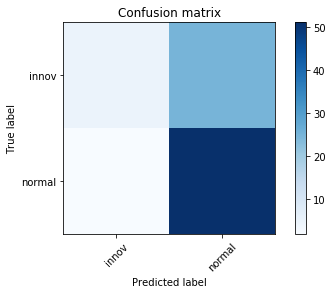


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.027s
test time:  0.000s
accuracy:   0.506
dimensionality: 3000
density: 0.984000
classification report:
              precision    recall  f1-score   support

       innov       0.34      0.40      0.37        30
      others       0.62      0.57      0.59        53

    accuracy                           0.51        83
   macro avg       0.48      0.48      0.48        83
weighted avg       0.52      0.51      0.51        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

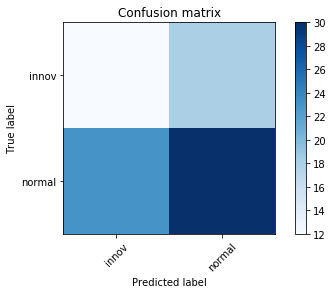


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)
train time: 0.087s
test time:  0.000s
accuracy:   0.530
dimensionality: 3000
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.37      0.43      0.40        30
      others       0.65      0.58      0.61        53

    accuracy                           0.53        83
   macro avg       0.51      0.51      0.51        83
weighted avg       0.55      0.53      0.54        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

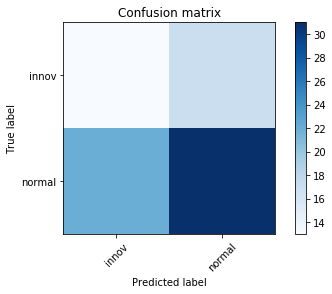


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
train time: 0.014s
test time:  0.108s
accuracy:   0.554
classification report:
              precision    recall  f1-score   support

       innov       0.32      0.20      0.24        30
      others       0.62      0.75      0.68        53

    accuracy                           0.55        83
   macro avg       0.47      0.48      0.46        83
weighted avg       0.51      0.55      0.53        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

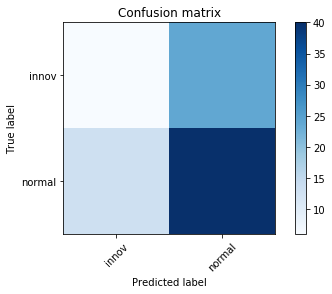


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train time: 2.455s
test time:  0.031s
accuracy:   0.699
classification report:
              precision    recall  f1-score   support

       innov       0.86      0.20      0.32        30
      others       0.68      0.98      0.81        53

    accuracy                           0.70        83
   macro avg       0.77      0.59      0.57      

<Figure size 432x288 with 0 Axes>

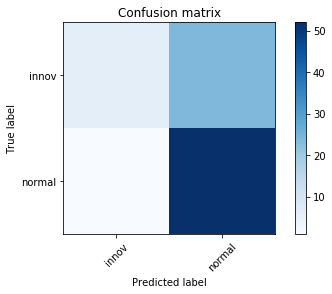


L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.128s
test time:  0.000s
accuracy:   0.627
dimensionality: 3000
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.45      0.17      0.24        30
      others       0.65      0.89      0.75        53

    accuracy                           0.63        83
   macro avg       0.55      0.53      0.50        83
weighted avg       0.58      0.63      0.57        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

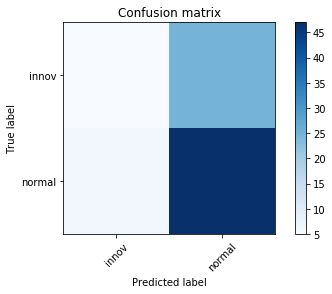


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.089s
test time:  0.002s
accuracy:   0.554
dimensionality: 3000
density: 0.998000
classification report:
              precision    recall  f1-score   support

       innov       0.38      0.37      0.37        30
      others       0.65      0.66      0.65        53

    accuracy                           0.55        83
   macro avg       0.51      0.51      0.51        83
weighted avg       0.55      0.55      0.55        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

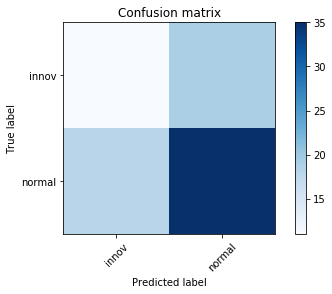


L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)
train time: 0.152s
test time:  0.003s
accuracy:   0.687
dimensionality: 3000
density: 0.084000
classification report:
              precision    recall  f1-score   support

       innov       0.75      0.20      0.32        30
      others       0.68      0.96      0.80        53

    accuracy                           0.69        83
   macro avg       0.72      0.58      0.56        83
weighted avg       0.71      0.69      0.62        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

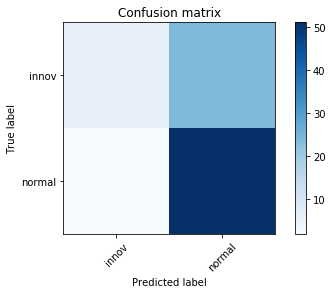


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.212s
test time:  0.001s
accuracy:   0.614
dimensionality: 3000
density: 0.285333
classification report:
              precision    recall  f1-score   support

       innov       0.45      0.33      0.38        30
      others       0.67      0.77      0.72        53

    accuracy                           0.61        83
   macro avg       0.56      0.55      0.55        83
weighted avg       0.59      0.61      0.60        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

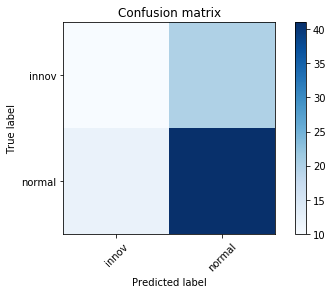


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.358s
test time:  0.007s
accuracy:   0.554
dimensionality: 3000
density: 0.777667
classification report:
              precision    recall  f1-score   support

       innov       0.39      0.40      0.39        30
      others       0.65      0.64      0.65        53

    accuracy                           0.55        83
   macro avg       0.52      0.52      0.52        83
weighted avg       0.56      0.55      0.56        83

confusion ma

<Figure size 432x288 with 0 Axes>

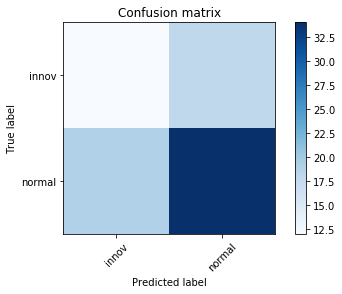


NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.034s
test time:  0.002s
accuracy:   0.614
classification report:
              precision    recall  f1-score   support

       innov       0.45      0.30      0.36        30
      others       0.67      0.79      0.72        53

    accuracy                           0.61        83
   macro avg       0.56      0.55      0.54        83
weighted avg       0.59      0.61      0.59        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

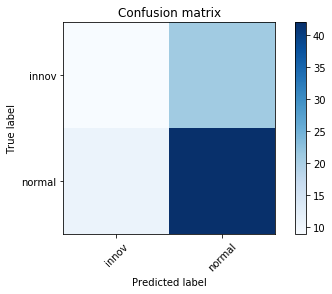


Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.005s
test time:  0.001s
accuracy:   0.663
dimensionality: 3000
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.67      0.13      0.22        30
      others       0.66      0.96      0.78        53

    accuracy                           0.66        83
   macro avg       0.66      0.55      0.50        83
weighted avg       0.66      0.66      0.58        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

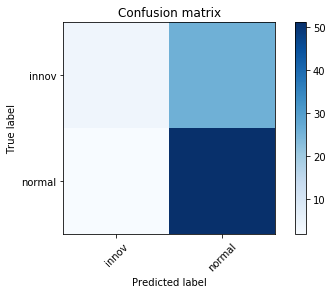


________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.018s
test time:  0.003s
accuracy:   0.566
dimensionality: 3000
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.44      0.70      0.54        30
      others       0.74      0.49      0.59        53

    accuracy                           0.57        83
   macro avg       0.59      0.60      0.56        83
weighted avg       0.63      0.57      0.57        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

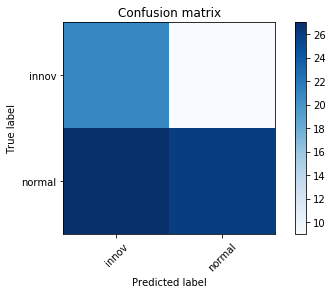


________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=False)
train time: 0.008s
test time:  0.001s
accuracy:   0.614
dimensionality: 3000
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.46      0.37      0.41        30
      others       0.68      0.75      0.71        53

    accuracy                           0.61        83
   macro avg       0.57      0.56      0.56        83
weighted avg       0.60      0.61      0.60        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

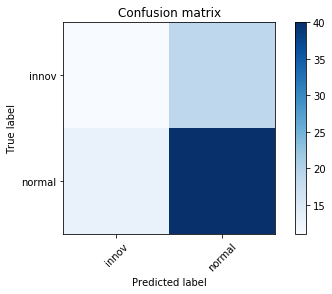


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
    

<Figure size 432x288 with 0 Axes>

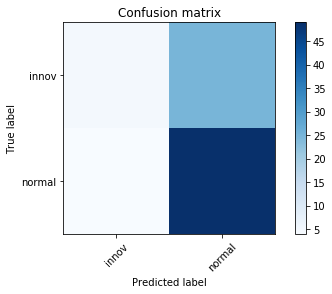

In [10]:
results = get_benchmark(x_train_v, y_train, x_test_v, y_test)

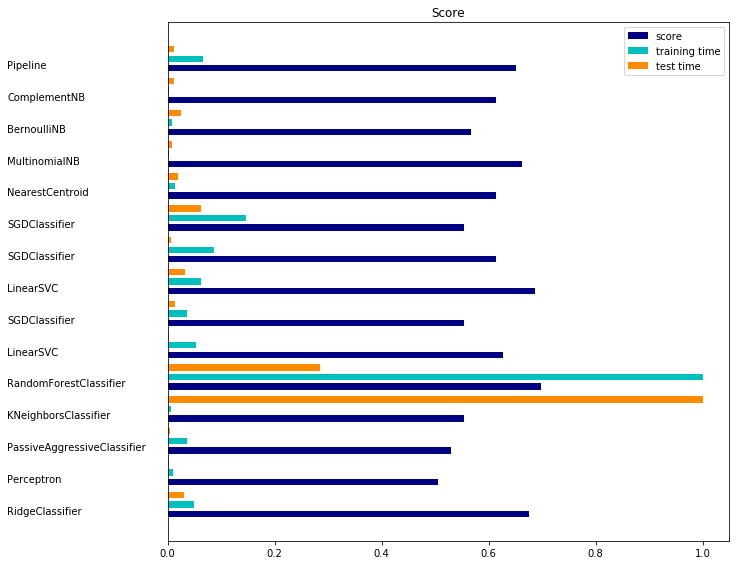

In [11]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [14]:
import gensim.downloader as api

In [73]:
wv = api.load("glove-wiki-gigaword-100")

In [17]:
def word_averaging(doc_tokenized,wv):    
    return np.array([np.mean([wv[w] for w in doc_tokenized[i] if w in wv], axis=0) for i,_ in enumerate(doc_tokenized)])


In [74]:
def map_f(name, size=100):
    if name in wv:
        return wv[name]
    return np.zeros(size)
wv_mat = np.array(list(map(map_f, c_vec.get_feature_names())))
doc_vec = (word_frequency @ wv_mat)

In [138]:
np.sum([1 for name in vec.get_feature_names() if name in wv])

2888

In [143]:
x_train_v.shape

(745, 3000)

In [148]:
np.vstack?

In [152]:
x_train_v.shape, x_test_v.shape

((745, 3000), (83, 3000))

In [161]:
wv_mat = np.array(list(map(map_f, vec.get_feature_names())))
doc_vec = (np.concatenate((x_train_v.toarray(), x_test_v.toarray())) @ wv_mat)

In [163]:
doc_vec.shape

(828, 100)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.111s
test time:  0.000s
accuracy:   0.578
dimensionality: 100
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.35      0.20      0.26        30
      others       0.64      0.79      0.71        53

    accuracy                           0.58        83
   macro avg       0.49      0.50      0.48        83
weighted avg       0.53      0.58      0.54        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

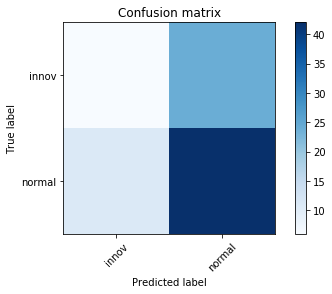


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.009s
test time:  0.000s
accuracy:   0.386
dimensionality: 100
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.37      1.00      0.54        30
      others       1.00      0.04      0.07        53

    accuracy                           0.39        83
   macro avg       0.69      0.52      0.31        83
weighted avg       0.77      0.39      0.24        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

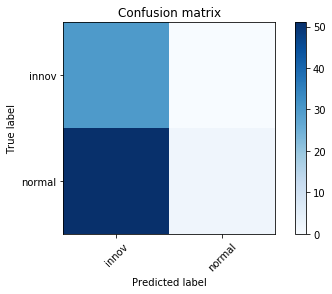


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)
train time: 0.007s
test time:  0.000s
accuracy:   0.386
dimensionality: 100
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.37      1.00      0.54        30
      others       1.00      0.04      0.07        53

    accuracy                           0.39        83
   macro avg       0.69      0.52      0.31        83
weighted avg       0.77      0.39      0.24        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

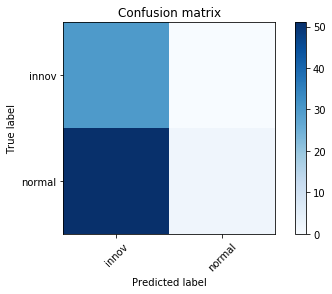


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
train time: 0.008s
test time:  0.071s
accuracy:   0.590
classification report:
              precision    recall  f1-score   support

       innov       0.38      0.20      0.26        30
      others       0.64      0.81      0.72        53

    accuracy                           0.59        83
   macro avg       0.51      0.51      0.49        83
weighted avg       0.55      0.59      0.55        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

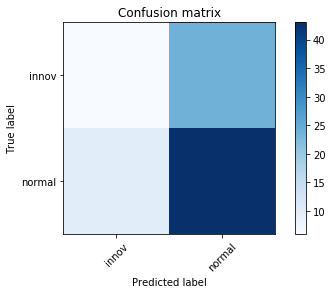


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train time: 1.359s
test time:  0.016s
accuracy:   0.590
classification report:
              precision    recall  f1-score   support

       innov       0.25      0.07      0.11        30
      others       0.63      0.89      0.73        53

    accuracy                           0.59        83
   macro avg       0.44      0.48      0.42      

<Figure size 432x288 with 0 Axes>

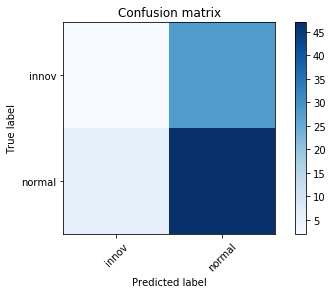


L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.038s
test time:  0.004s
accuracy:   0.530
dimensionality: 100
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.29      0.20      0.24        30
      others       0.61      0.72      0.66        53

    accuracy                           0.53        83
   macro avg       0.45      0.46      0.45        83
weighted avg       0.49      0.53      0.51        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

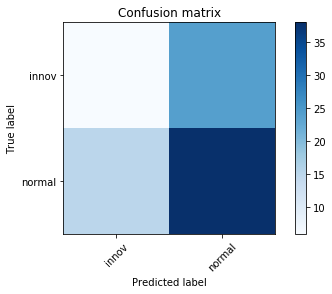


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.015s
test time:  0.001s
accuracy:   0.639
dimensionality: 100
density: 1.000000
classification report:
              precision    recall  f1-score   support

       innov       0.00      0.00      0.00        30
      others       0.64      1.00      0.78        53

    accuracy                           0.64        83
   macro avg       0.32      0.50      0.39        83
weighted avg       0.41      0.64      0.50        83

confusion matrix:


/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

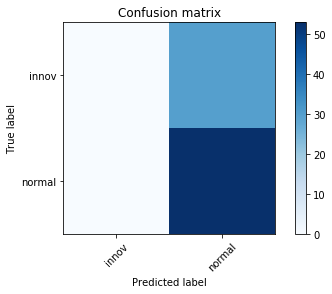


L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)
train time: 0.264s
test time:  0.000s
accuracy:   0.542
dimensionality: 100
density: 0.840000
classification report:
              precision    recall  f1-score   support

       innov       0.32      0.23      0.27        30
      others       0.62      0.72      0.67        53

    accuracy                           0.54        83
   macro avg       0.47      0.48      0.47        83
weighted avg       0.51      0.54      0.52        83

confusion matrix:


/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

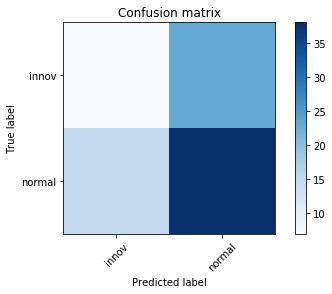


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.073s
test time:  0.001s
accuracy:   0.627
dimensionality: 100
density: 0.970000
classification report:
              precision    recall  f1-score   support

       innov       0.33      0.03      0.06        30
      others       0.64      0.96      0.77        53

    accuracy                           0.63        83
   macro avg       0.49      0.50      0.41        83
weighted avg       0.53      0.63      0.51        83

confusion matrix:


/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

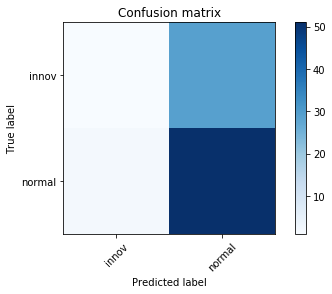


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.038s
test time:  0.000s
accuracy:   0.518
dimensionality: 100
density: 0.980000
classification report:
              precision    recall  f1-score   support

       innov       0.32      0.30      0.31        30
      others       0.62      0.64      0.63        53

    accuracy                           0.52        83
   macro avg       0.47      0.47      0.47        83
weighted avg       0.51      0.52      0.51        83

confusion mat

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

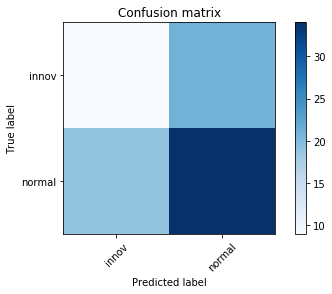


NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.001s
accuracy:   0.542
classification report:
              precision    recall  f1-score   support

       innov       0.39      0.50      0.44        30
      others       0.67      0.57      0.61        53

    accuracy                           0.54        83
   macro avg       0.53      0.53      0.53        83
weighted avg       0.57      0.54      0.55        83

confusion matrix:


<Figure size 432x288 with 0 Axes>

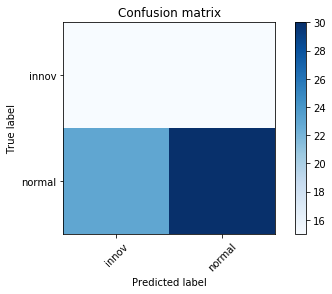


Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)


ValueError: Negative values in data passed to MultinomialNB (input X)

In [165]:
get_benchmark(doc_vec[x_train.index], y_train, doc_vec[x_test.index], y_test)

In [173]:
from sklearn import preprocessing, decomposition
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



countvec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english', binary=True)
# Fit and transform CountVectorizer to both training and test sets
countvec.fit(corpus_en.raw(id) for id in df['id'])
X_train_countvec =  countvec.transform(corpus_en.raw(id) for id in x_train) 
X_test_countvec = countvec.transform(corpus_en.raw(id) for id in x_test)

svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train_countvec)
X_train_svd = svd.transform(X_train_countvec)
X_test_svd = svd.transform(X_test_countvec)

scale = preprocessing.StandardScaler()
scale.fit(X_train_svd)
X_train_svd_scale = scale.transform(X_train_svd)
X, y = X_train_svd_scale, y_train
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.5, 1.01), cv=cv, n_jobs=4)
plt.show();

In [ ]:
wv_mat = np.array(list(map(map_f, vec.get_feature_names())))
doc_vec = ( @ wv_mat)


## dutch

In [2]:
with open('./dictionary_nl.picle', 'rb') as f:
    features_nl = pickle.load(f)

In [10]:
stop_nl = set(stopwords.words('dutch'))
punctuation = set(w for w in string.punctuation)
stop_nl.update(punctuation)

In [11]:
#construct frequency table
if 'features_nl' not in globals():
    features_nl = FreqDist(w for w in word_dict(corpus_nl, stop_nl))
    with open('./dictionary_nl.picle', 'wb') as f:
        pickle.dump(features_nl, f)

In [12]:
print('vocabulary: {}'.format(len(features_nl)))
features_nl.most_common(10)

vocabulary: 446667


[('digit', 511834),
 ('onze', 147960),
 ('wij', 117033),
 ('we', 108940),
 ('cookies', 52082),
 ('website', 50466),
 ('contact', 50349),
 ('informatie', 47218),
 ('kunt', 45249),
 ('’', 43640)]

In [13]:
_ = ((k,v) for k,v in features_nl.items())
keys = sorted(_, key = lambda x: x[1], reverse=True)

In [14]:
# step through the keys from most frequent to least with 2000 step size
for i in range(0,len(keys),2000):
    print(i, keys[i])

0 ('digit', 511834)
2000 ('enschede', 1023)
4000 ('zwembad', 454)
6000 ('beantwoord', 283)
8000 ('configuratie', 197)
10000 ('gamers', 148)
12000 ('monegier', 116)
14000 ('bmd', 94)
16000 ('gehuisvest', 78)
18000 ('neptunus', 67)
20000 ('6a', 58)
22000 ('klaarstaan', 50)
24000 ('stadsbouwhuis', 45)
26000 ('18v', 40)
28000 ('88-4637700', 36)
30000 ('trottoirs', 32)
32000 ('tekenkamer', 29)
34000 ('aangescherpte', 27)
36000 ('nachthemd', 25)
38000 ('progetti', 23)
40000 ('reagentia', 21)
42000 ('quinny', 20)
44000 ('monumentendag', 18)
46000 ('instruction', 17)
48000 ('rolluik', 16)
50000 ('pleister', 15)
52000 ('unauthorized', 14)
54000 ('it-gebied', 13)
56000 ('beukers', 12)
58000 ('diervoederveiligheid', 12)
60000 ('siliconenkitten', 11)
62000 ('motherless', 11)
64000 ('doorloopsnelheid', 10)
66000 ("xapvandenberg.nl'.replace", 10)
68000 ('vrieskasten', 9)
70000 ('orionweg', 9)
72000 ('zubehör', 8)
74000 ('olsen', 8)
76000 ('rundveevoeding', 8)
78000 ('m²/', 8)
80000 ('novel', 7)
8200

In [15]:
# slice the dictionary to reduce size (take only word with frequency >= 5)
nl_dict = list(features_nl.most_common(110000))
nl_dict = (k for k,v in nl_dict)

In [19]:
#transform document to tf-idf vector
df = generate_test_train_split(corpus_nl)
x_train,x_test, y_train, y_test = train_test_split(df['id'], df['innov'], random_state = 42, test_size = 0.15)
tfidf = TfidfVectorizer(preprocessor= preprocessor, tokenizer = tokenizer, lowercase=True, vocabulary=nl_dict)
x_train_feature = tfidf.fit_transform(corpus_nl.raw(id) for id in x_train)
x_test_feature = tfidf.transform(corpus_nl.raw(id) for id in x_test)

In [24]:
x_train_feature.shape, x_test_feature.shape, y_train.shape, y_test.shape

((3360, 110000), (594, 110000), (3360,), (594,))

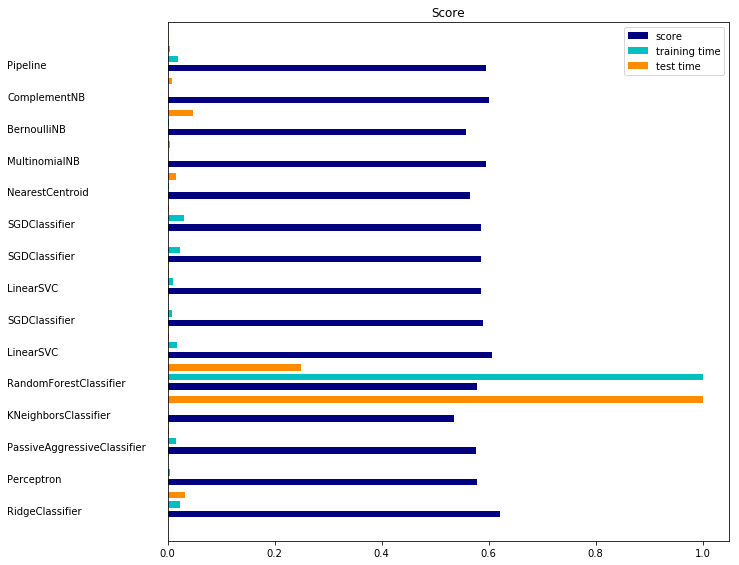

In [27]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [28]:
from sklearn.model_selection import learning_curve

In [49]:
tfidf = TfidfVectorizer(preprocessor= preprocessor, tokenizer = tokenizer, lowercase=True, vocabulary=nl_dict)

In [47]:
# slice the dictionary to reduce size (take only word with frequency >= 5)
nl_dict = list(features_nl.most_common(110000))
nl_dict = (k for k,v in nl_dict)

In [50]:
x = tfidf.fit_transform(corpus_nl.raw(id) for id in df['id'])

In [51]:
x.shape

(3954, 110000)

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [68]:
train_sizes, train_scores, valid_scores = learning_curve(LinearSVC(penalty='l2', dual=False,
                                           tol=1e-3), x, df['innov'], cv=5, shuffle=True,
                                                         train_sizes=np.arange(1000,3000,400))

In [71]:
train_scores,valid_scores

(array([[0.987     , 0.99      , 0.985     , 0.99      , 0.985     ],
        [0.98142857, 0.98214286, 0.98285714, 0.98642857, 0.98357143],
        [0.97611111, 0.97833333, 0.97833333, 0.985     , 0.98222222],
        [0.97409091, 0.975     , 0.97681818, 0.98045455, 0.97909091],
        [0.97230769, 0.97115385, 0.97307692, 0.97576923, 0.97653846]]),
 array([[0.5840708 , 0.58154235, 0.58280657, 0.57395702, 0.58734177],
        [0.57901391, 0.5840708 , 0.60429836, 0.56637168, 0.57594937],
        [0.57522124, 0.58027813, 0.61314791, 0.58027813, 0.59367089],
        [0.57522124, 0.58659924, 0.61441214, 0.57901391, 0.58101266],
        [0.56510746, 0.59039191, 0.61441214, 0.58533502, 0.58101266]]))

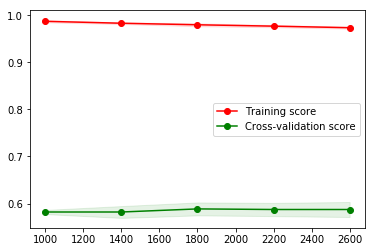

In [81]:
train_scores_mean = np.mean(train_scores,axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std, alpha=0.1,
                         color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")

In [85]:
from sklearn.metrics import confusion_matrix